<img src = "https://user-images.githubusercontent.com/8075494/39086572-80874e5a-4561-11e8-9a05-e52b21a3e580.png" width=400>

## What is OnlineStats?

- Single-pass, O(1) memory algorithms for statistics

# OnlineStats Basics

- Each statistic/model is a type
- Stats can be `fit!`-ted with more data
- Stats can be `merge!`-ed together

In [37]:
using OnlineStats

o = Mean()

Mean: n=0 | value=0.0

In [39]:
y = randn(10^6)

fit!(o, y)

Mean: n=2000000 | value=-0.000108879

### Statistics can optionally weight observations differently:

```julia
Mean(weight = EqualWeight())
Mean(weight = x -> .1)
```

![](https://user-images.githubusercontent.com/8075494/38169834-e15b1b32-3542-11e8-8789-e6f6e3296e8e.gif)

# What Can OnlineStats Do?

- A **sample** of what OnlineStats can do is shown below

## Summary Statistics

### Mean

In [40]:
fit!(Mean(), y)

Mean: n=1000000 | value=-0.00172493

In [41]:
mean(y)

-0.0017249302712044206

### Variance

In [42]:
fit!(Variance(), y)

Variance: n=1000000 | value=0.997388

In [43]:
var(y)

0.9973881929213255

### Extrema

In [44]:
fit!(Extrema(), y)

Extrema: n=1000000 | value=(-4.69909, 5.30759)

In [45]:
extrema(y)

(-4.699094854780792, 5.307594592921013)

# Quantiles

- This is harder since we can't sort

In [46]:
quantile(y, .5)

-0.0031935723912000697

## Stochastic Approximation

- Fast, but not always reliable

In [47]:
fit!(Quantile([.5], alg=SGD()), y)

Quantile: n=1000000 | value=[0.000329528]

In [48]:
fit!(Quantile([.5], alg=MSPI()), y)

Quantile: n=1000000 | value=[0.000167482]

In [49]:
fit!(Quantile([.5], alg=OMAS()), y)

Quantile: n=1000000 | value=[0.000711053]

## P-Squared Algorithm

- Slower, but more accurate

In [50]:
fit!(P2Quantile(), y)

P2Quantile(0.5, -0.0032258267860835878)

## Histogram-Based

In [51]:
o = fit!(Hist(200), y)

quantile(o, .5)

0.008658877844018621

In [52]:
o2 = fit!(Hist(-5:.01:5), y)

quantile(o2, .5)

-0.005000000000000001

### Side Note: Many Stats can be Plotted

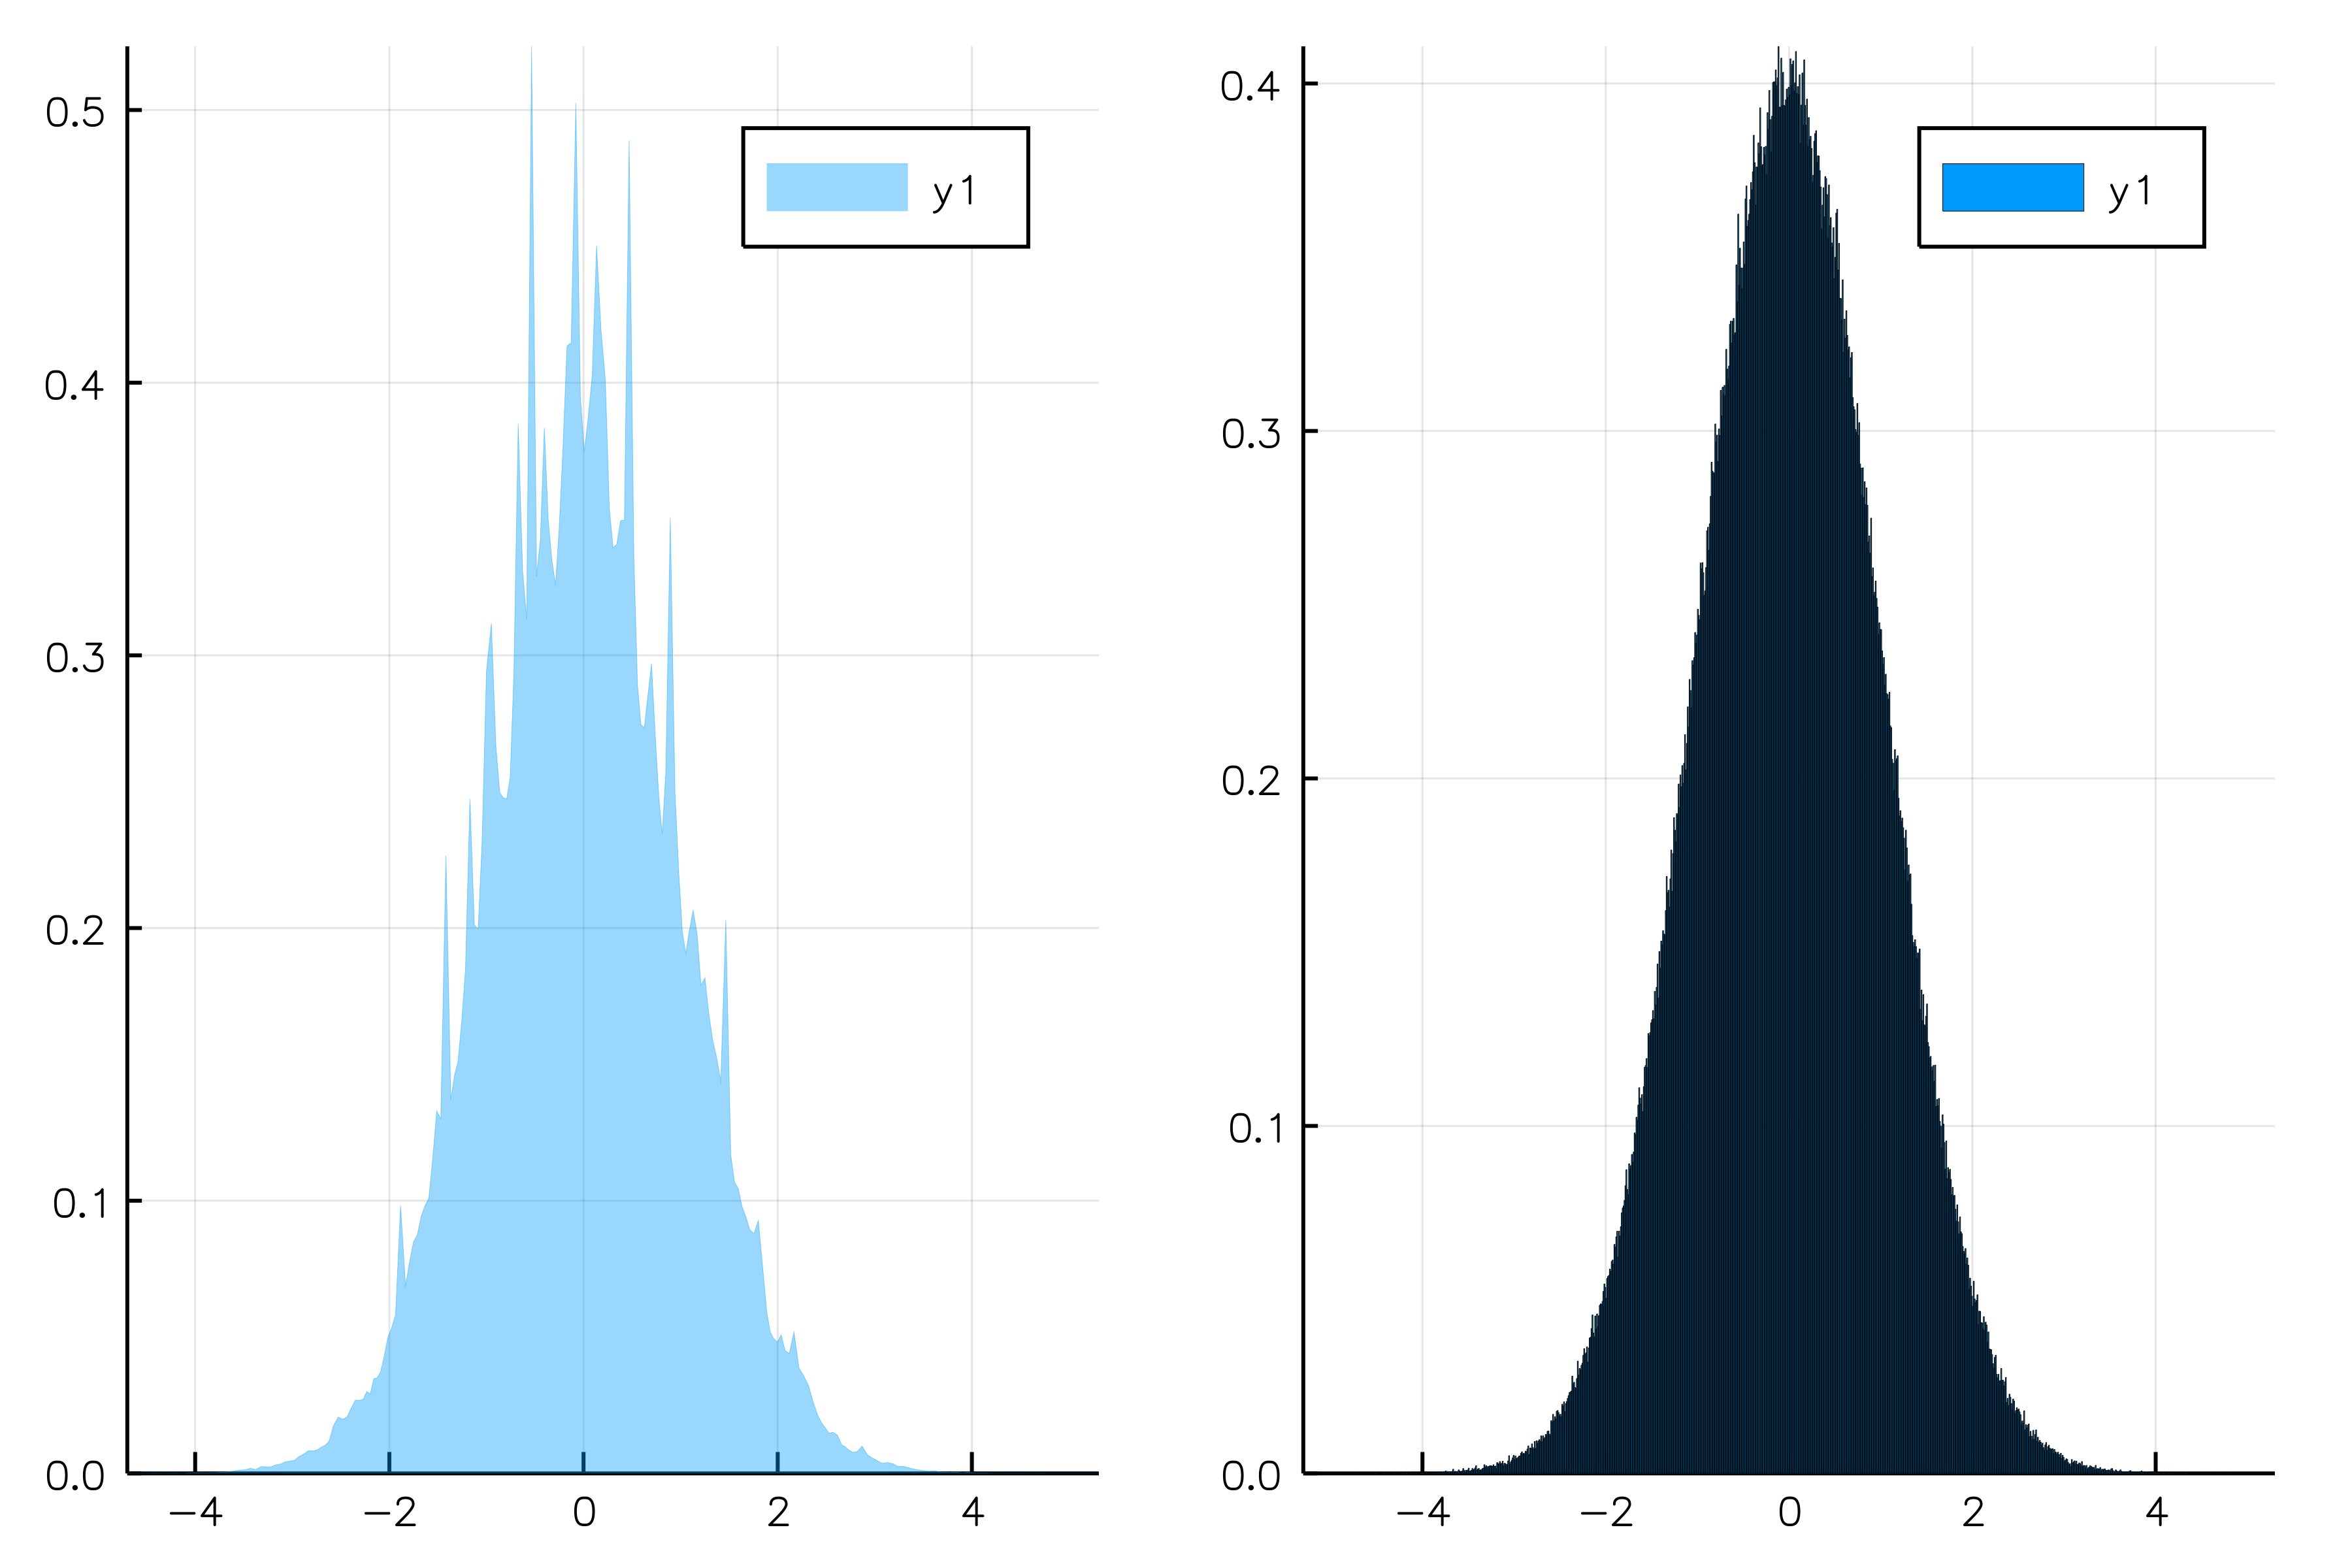

In [53]:
using Plots; gr(fmt=:png)

plot(plot(o), plot(o2, linewidth=0))

# Big Data Visualizations

## Mosaic Plots

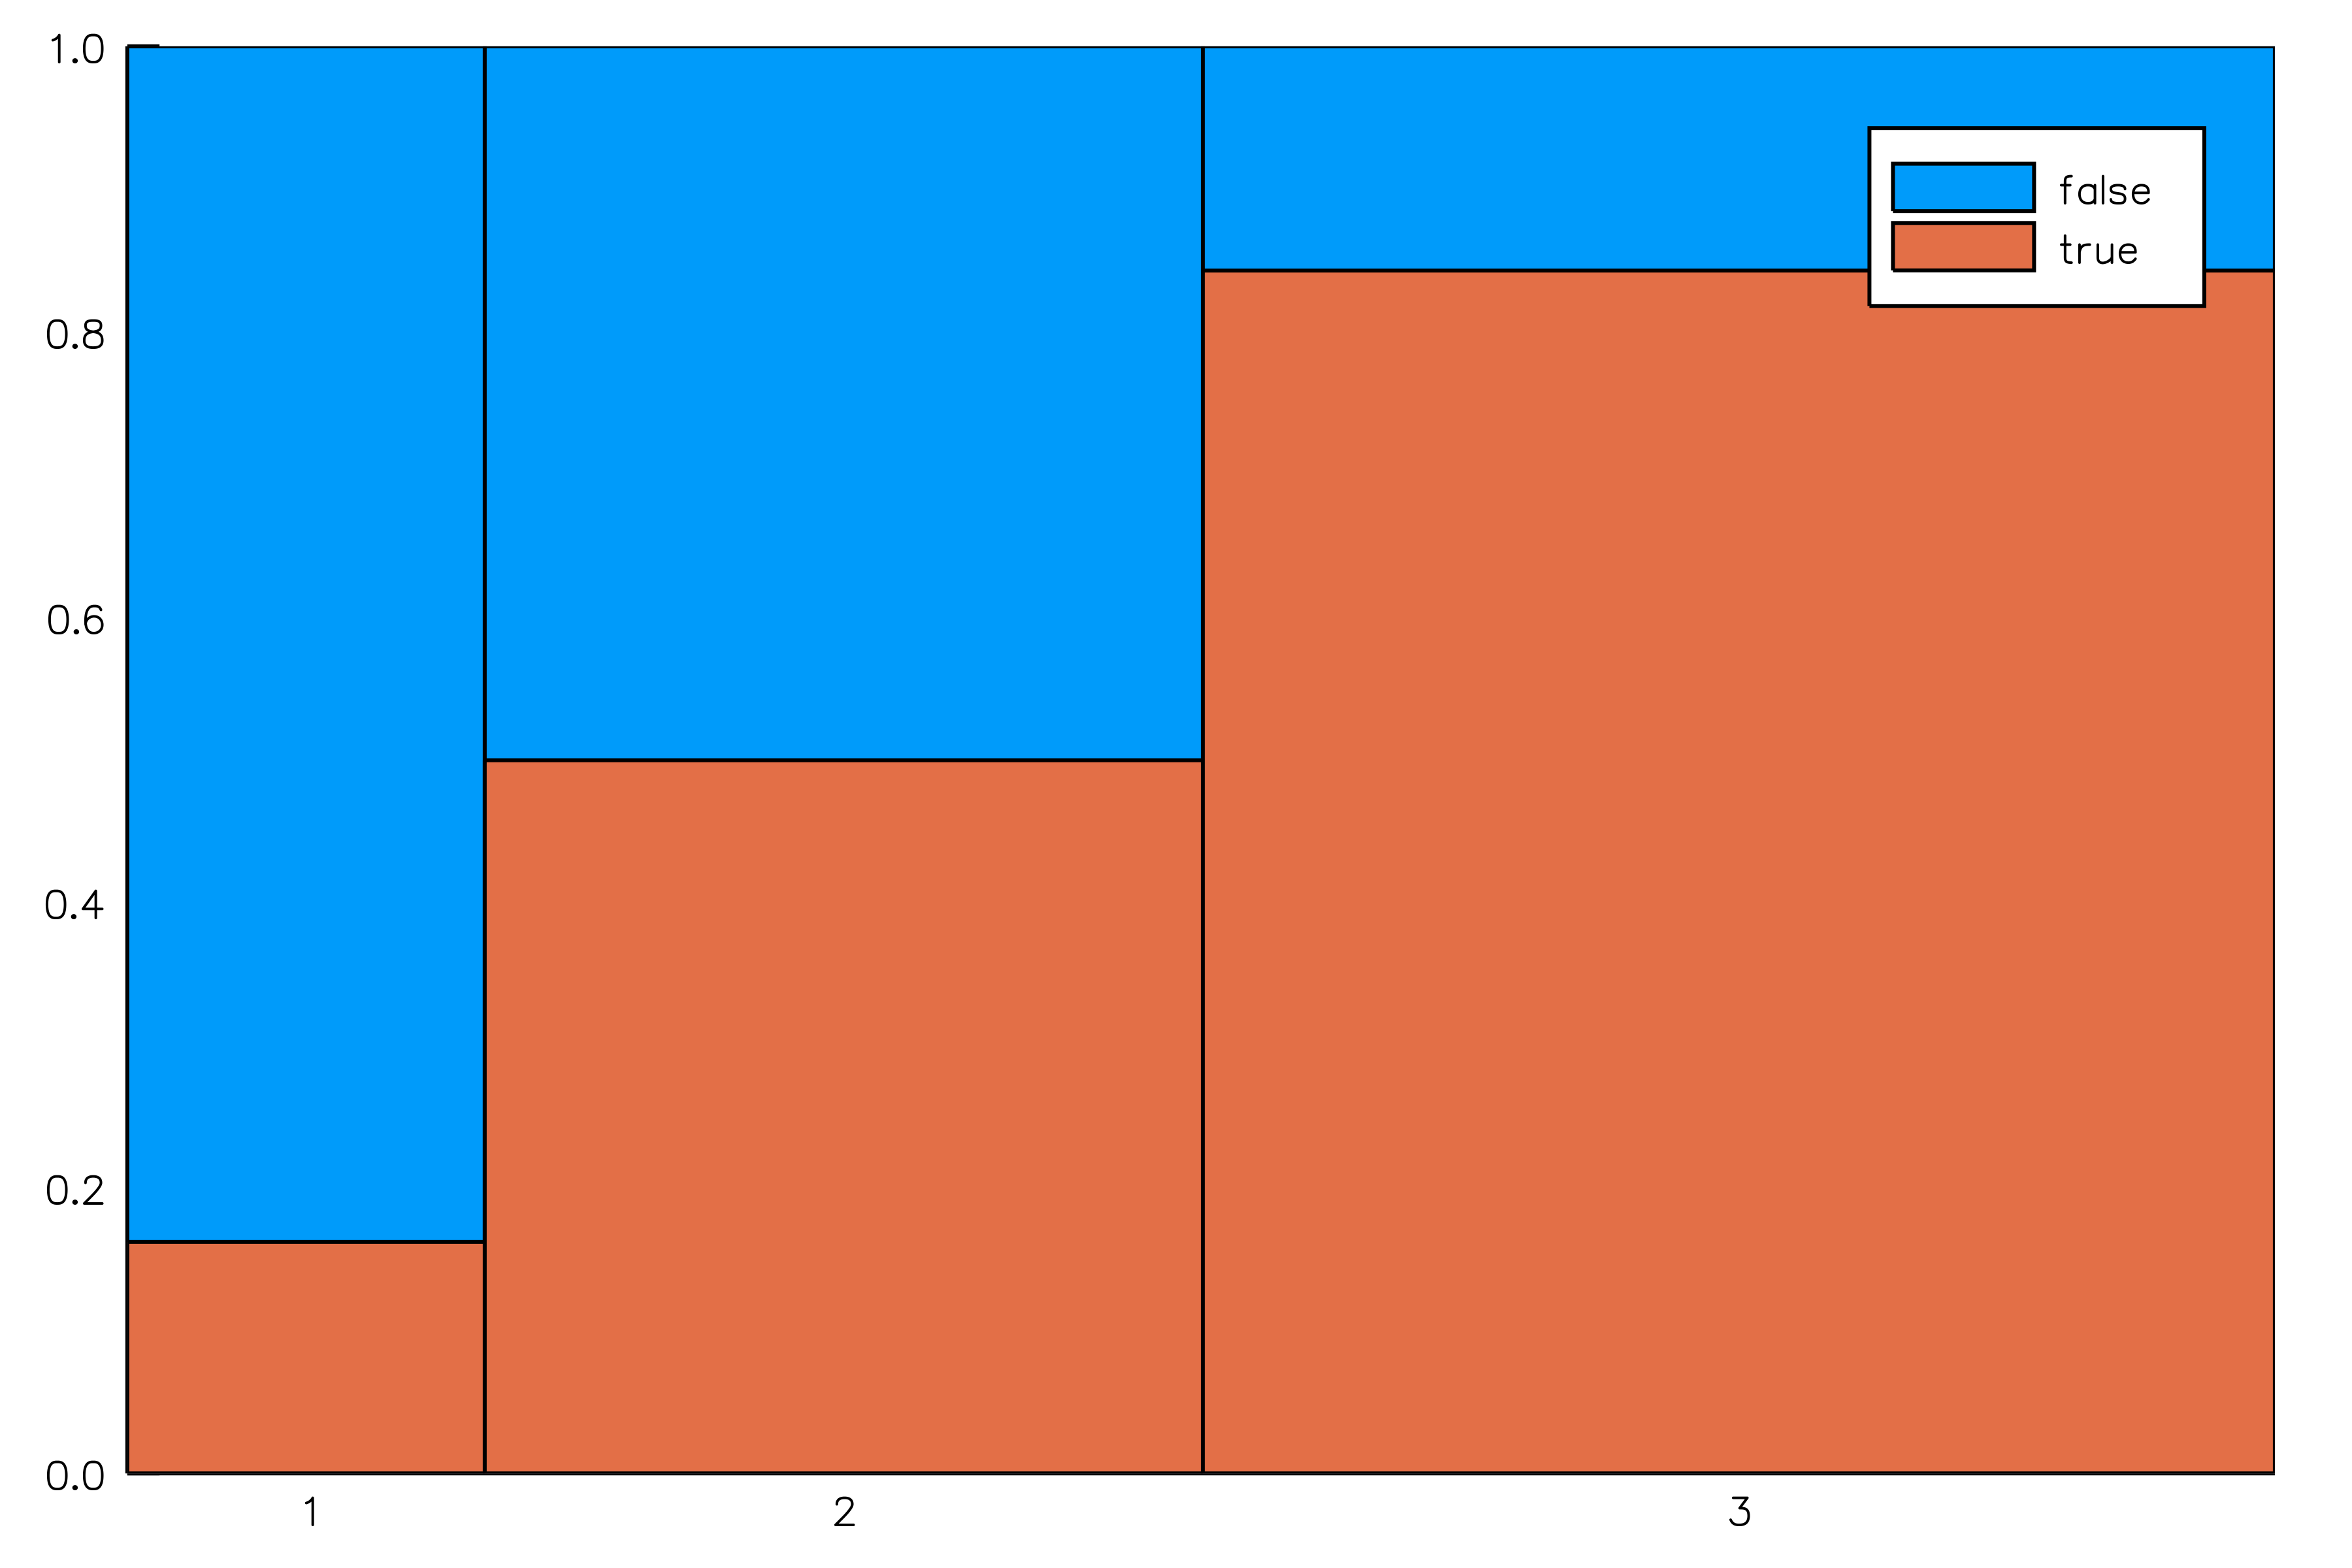

In [54]:
x = rand([1,2,2,3,3,3], 10^5)
y = x .+ randn(10^5) .> 2

o = fit!(Mosaic(Int, Bool), zip(x,y))

plot(o)

## Plotting Summaries of a Data Stream

- Idea: 
    - Group together observations on the X-axis
    - Plot a summary of the data for each group
    
- As data is `fit!`-ted, groups are `merge!`-ed together to "make room"

Interact.Options{:ToggleButtons,OnlineStatsBase.OnlineStat}(5: "input-2" = Mean: n=0 | value=0.0 OnlineStatsBase.OnlineStat , "stat", Mean: n=0 | value=0.0, "Mean: n=0 | value=0.0", 1, Interact.OptionDict(DataStructures.OrderedDict{String,OnlineStatsBase.OnlineStat}("Mean: n=0 | value=0.0"=>Mean: n=0 | value=0.0,"Extrema: n=0 | value=(Inf, -Inf)"=>Extrema: n=0 | value=(Inf, -Inf),"Hist: n=0 | value=(Float64[], Int64[])"=>Hist: n=0 | value=(Float64[], Int64[])), Dict{OnlineStatsBase.OnlineStat,String}(Pair{OnlineStatsBase.OnlineStat,String}(Mean: n=0 | value=0.0, "Mean: n=0 | value=0.0"),Pair{OnlineStatsBase.OnlineStat,String}(Hist: n=0 | value=(Float64[], Int64[]), "Hist: n=0 | value=(Float64[], Int64[])"),Pair{OnlineStatsBase.OnlineStat,String}(Extrema: n=0 | value=(Inf, -Inf), "Extrema: n=0 | value=(Inf, -Inf)"))), Any[], Any[], true, "horizontal", true)

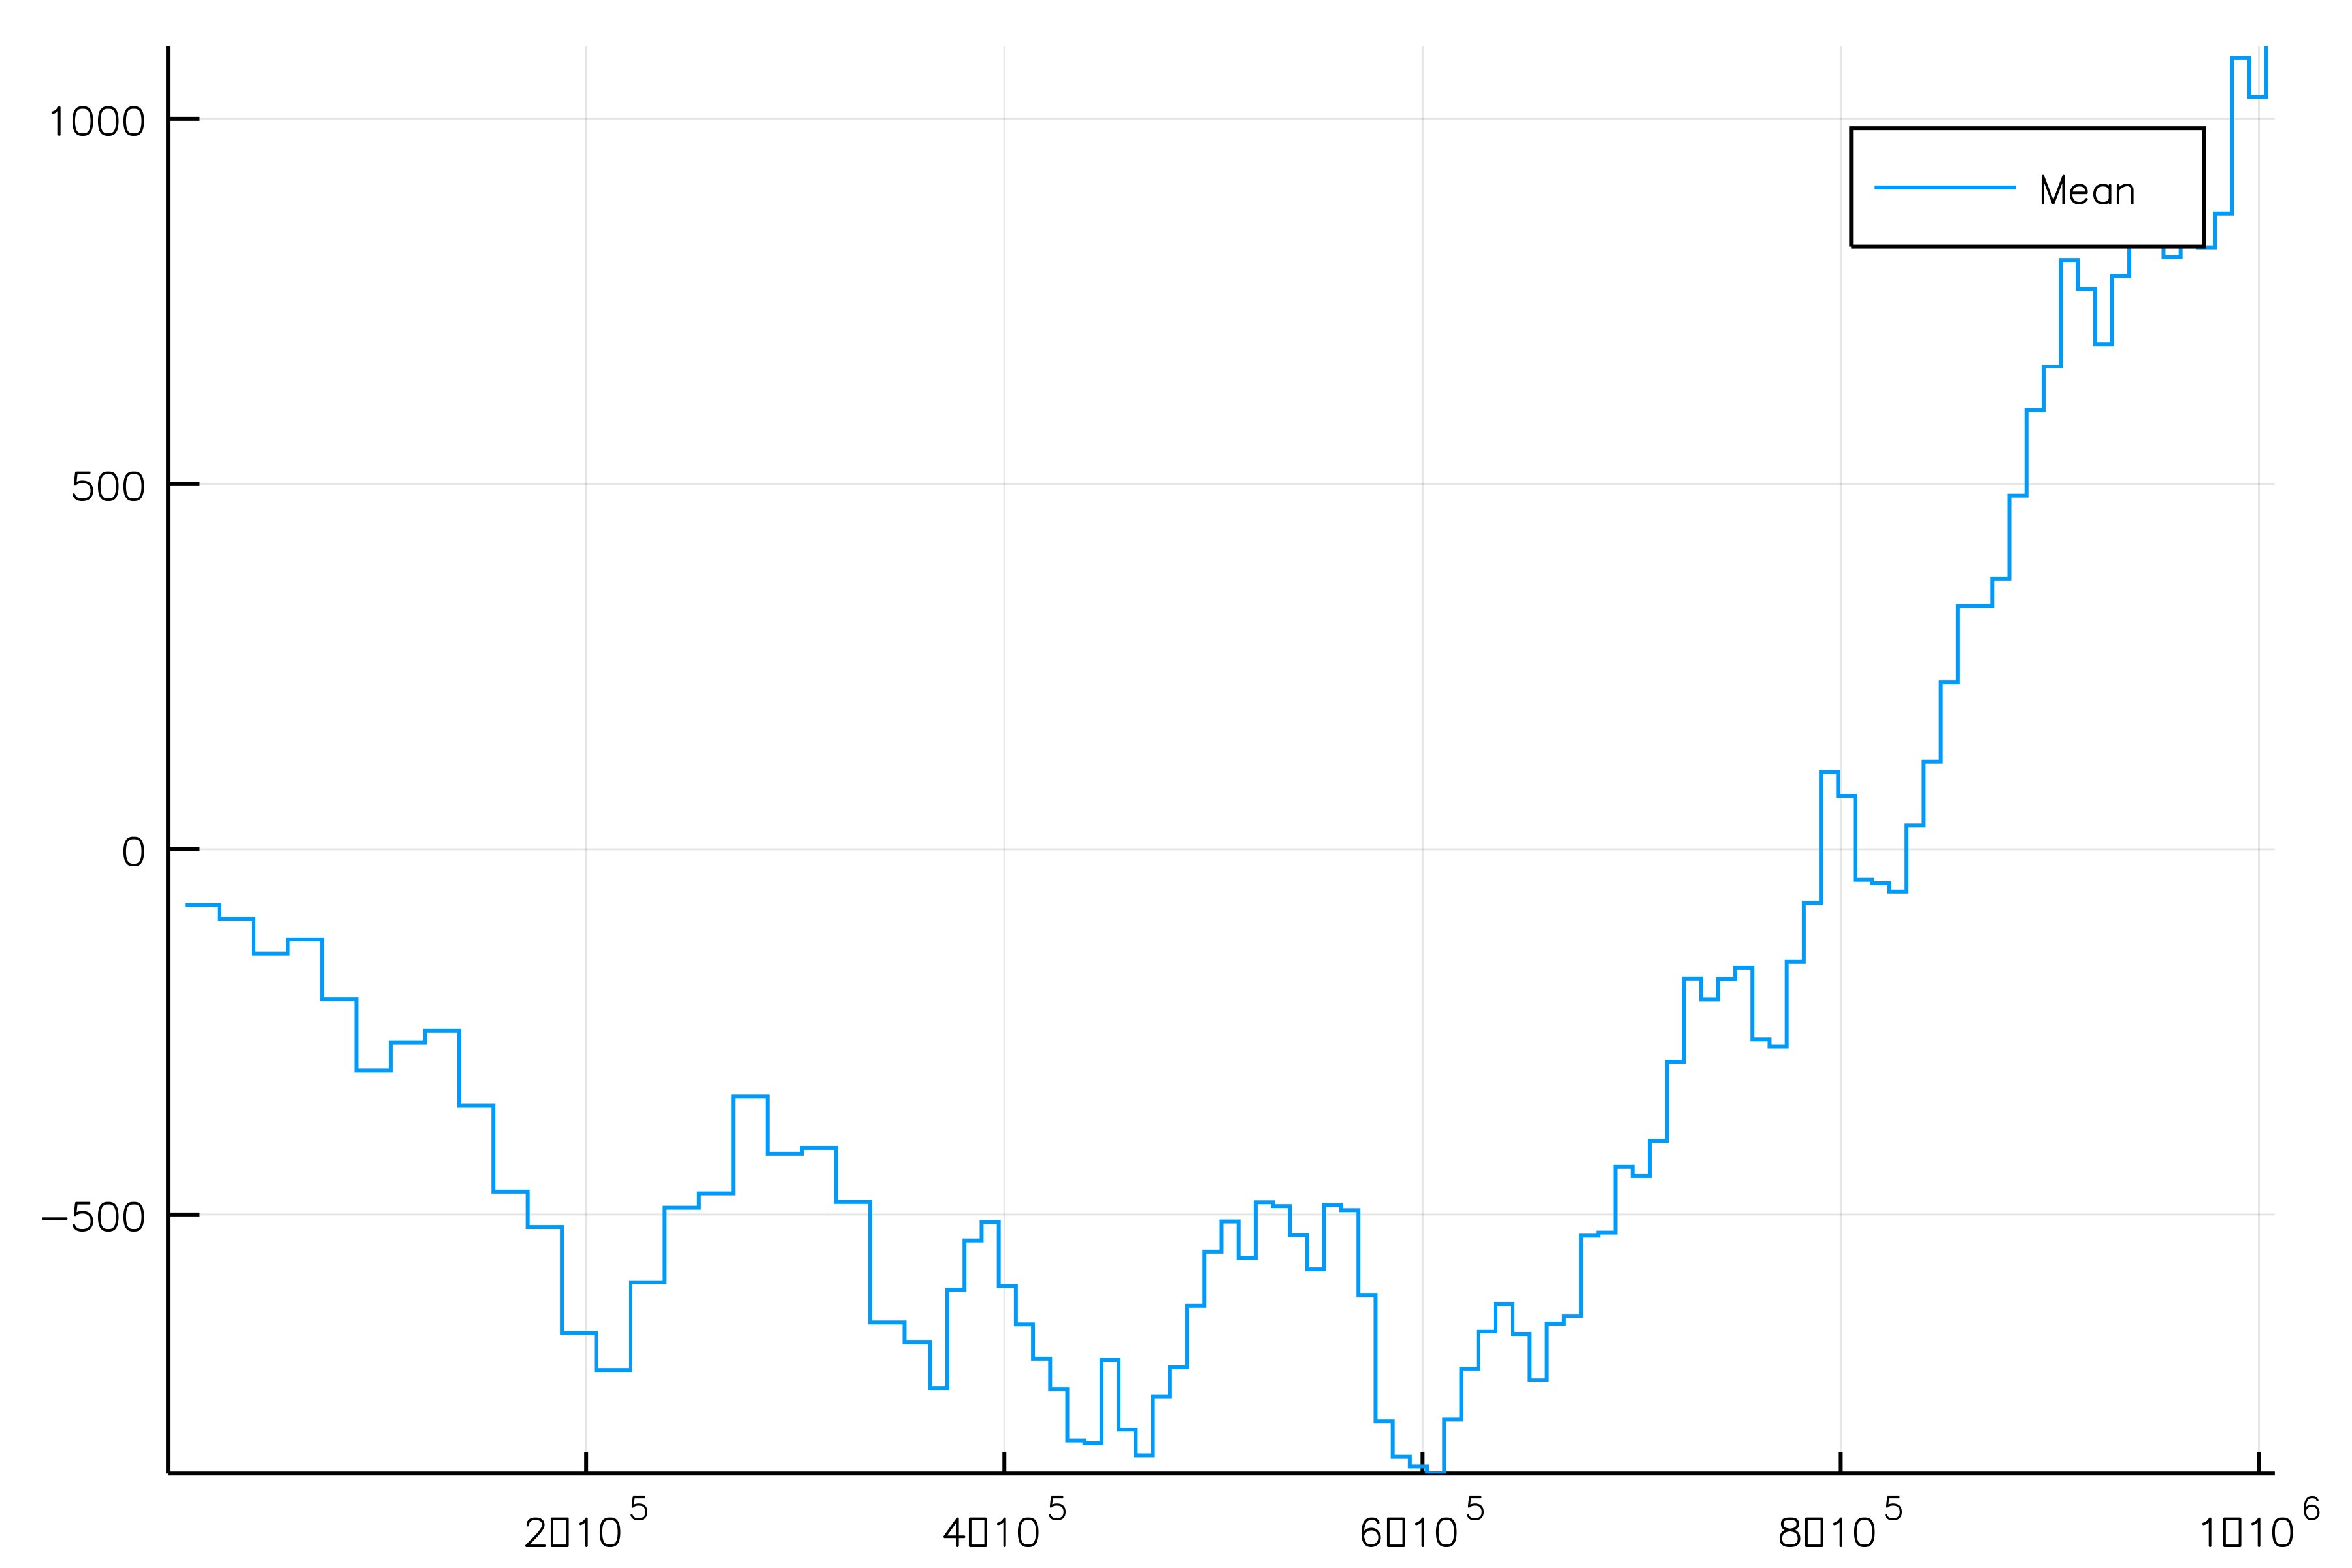

In [55]:
y = cumsum(randn(10^6)) .+ 10randn(10^6)

using Interact

@manipulate for stat in [Mean(), Extrema(), Hist(10)]
    plot(fit!(Partition(stat), y))
end

## Plotting Bivariate Summaries

- Same idea as above, but group observations together based on another variable vs. the order in which they are observed

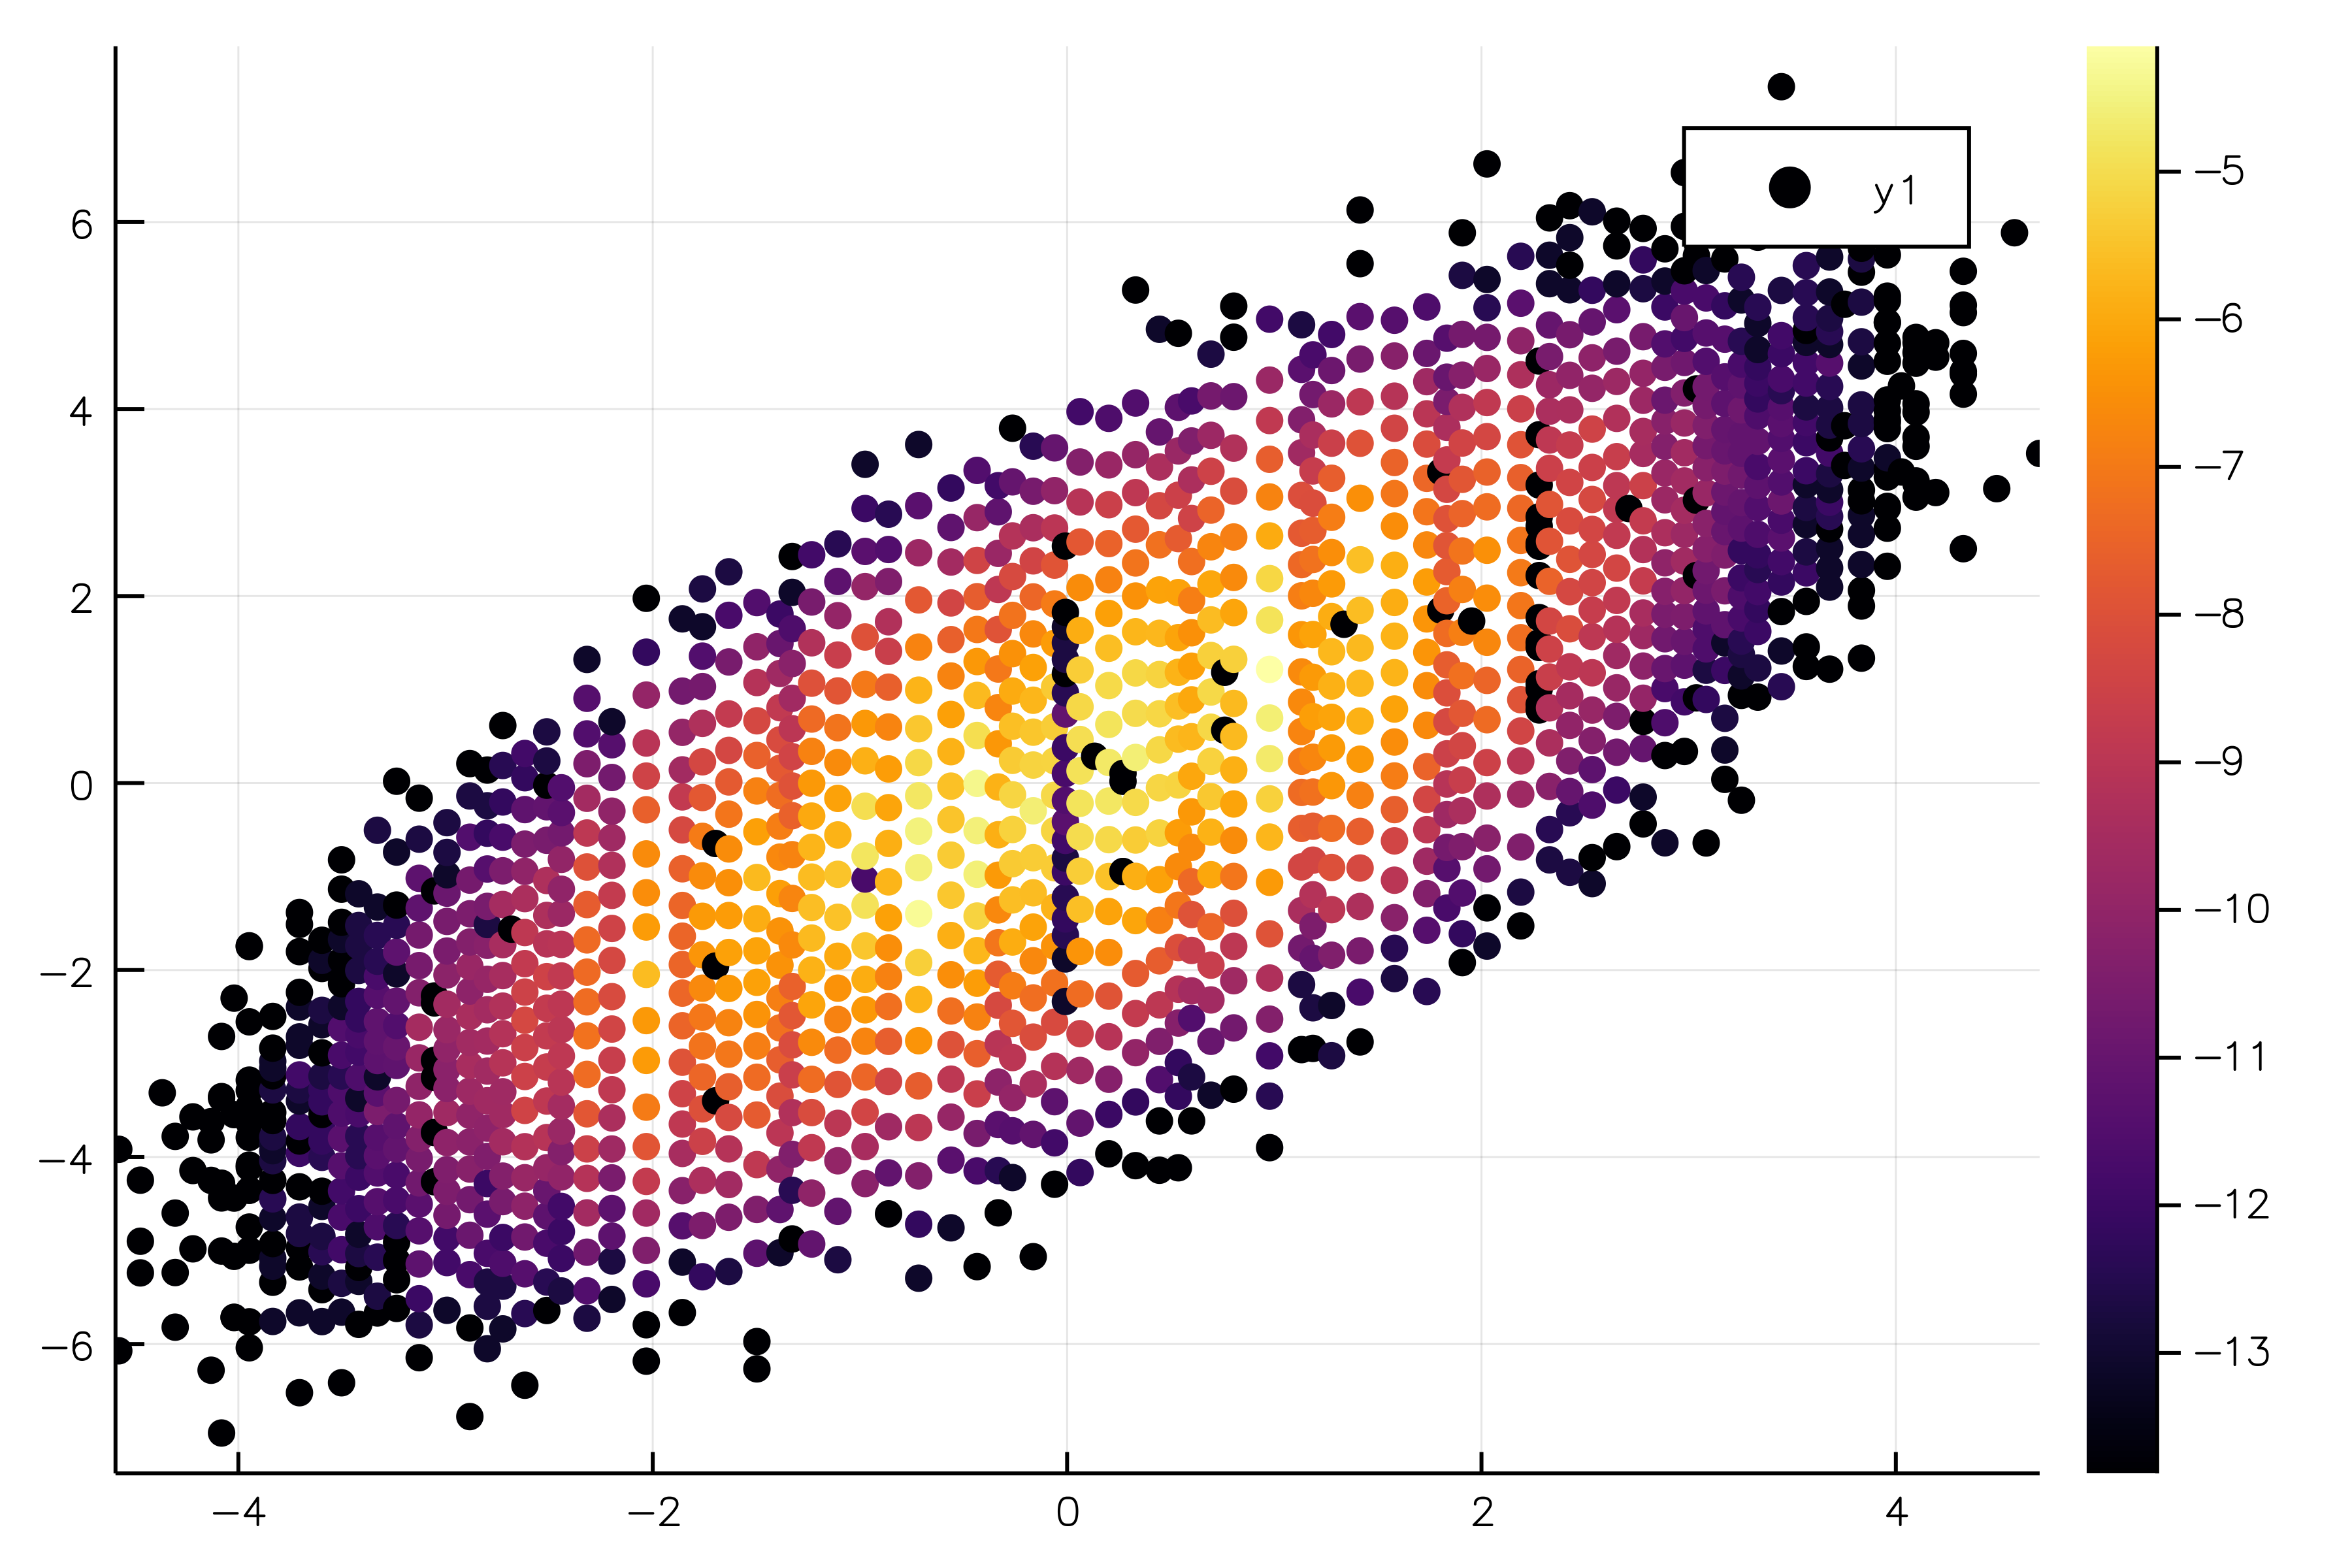

In [56]:
x = randn(10^6)
y = x .+ randn(10^6)

plot(fit!(IndexedPartition(Float64, Hist(20)), zip(x,y)))

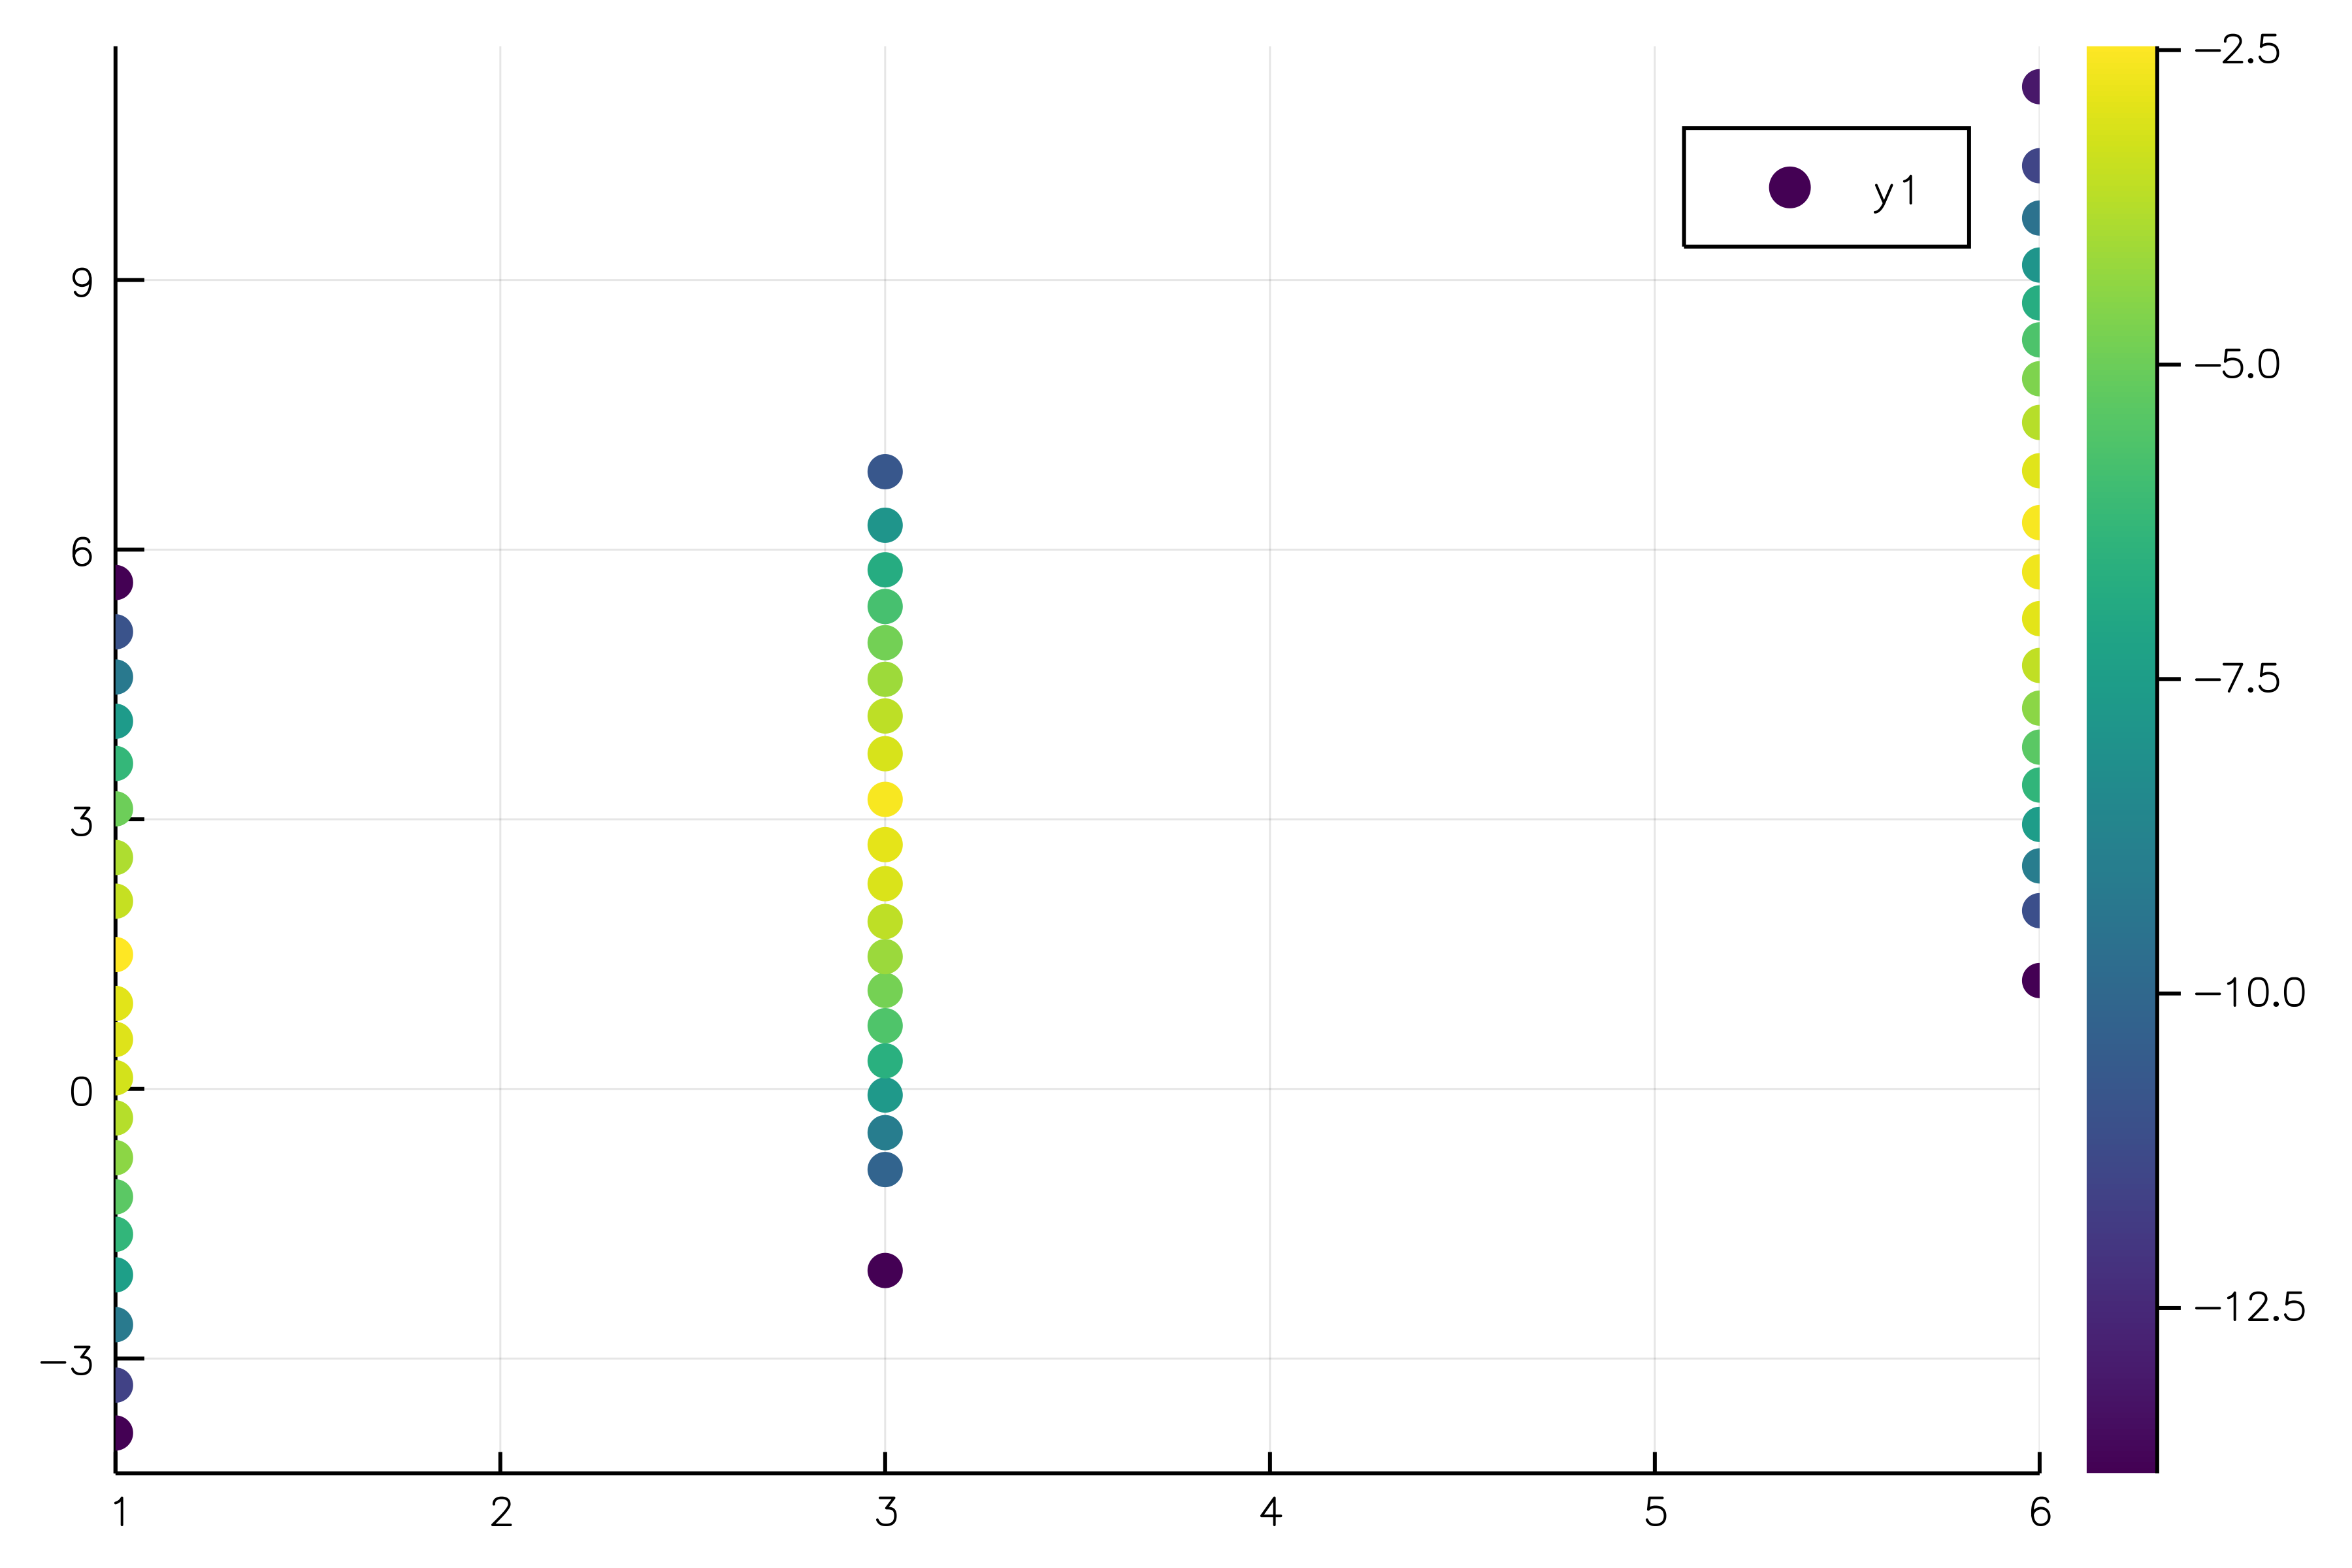

In [20]:
x = rand([1,3,6], 10^6)
y = x .+ randn(10^6)

plot(fit!(IndexedPartition(Int, Hist(20)), zip(x,y)), color=:viridis, ms=5)

# Statistical Models

## Linear Regression

In [21]:
x = randn(10^6, 5)

y = x * linspace(-1, 1, 5) + randn(10^6)

fit!(LinReg(), (x,y))

LinReg: n=1000000 | value=[-1.00071, -0.501712, 0.00063485, 0.501276, 0.999771]

In [22]:
xy = [x y]

o = fit!(LinRegBuilder(), xy)

LinRegBuilder of 6 variables

In [23]:
coef(o, x=1:5, y=6, bias=false)

5-element Array{Float64,1}:
 -1.00071   
 -0.501712  
  0.00063485
  0.501276  
  0.999771  

## Naive Bayes Classifier

In [24]:
x = randn(10^5, 10)
y = rand([1,2,2,3,3,3,4,4,4,4], 10^5)

o = fit!(NBClassifier(10, Int), (x,y))

NBClassifier
    > 3 (0.3006)
    > 4 (0.3983)
    > 2 (0.2012)
    > 1 (0.1)

In [25]:
mean(y .== classify(o, x))

0.36206

### Plotting the object plots the conditional distributions of each variable

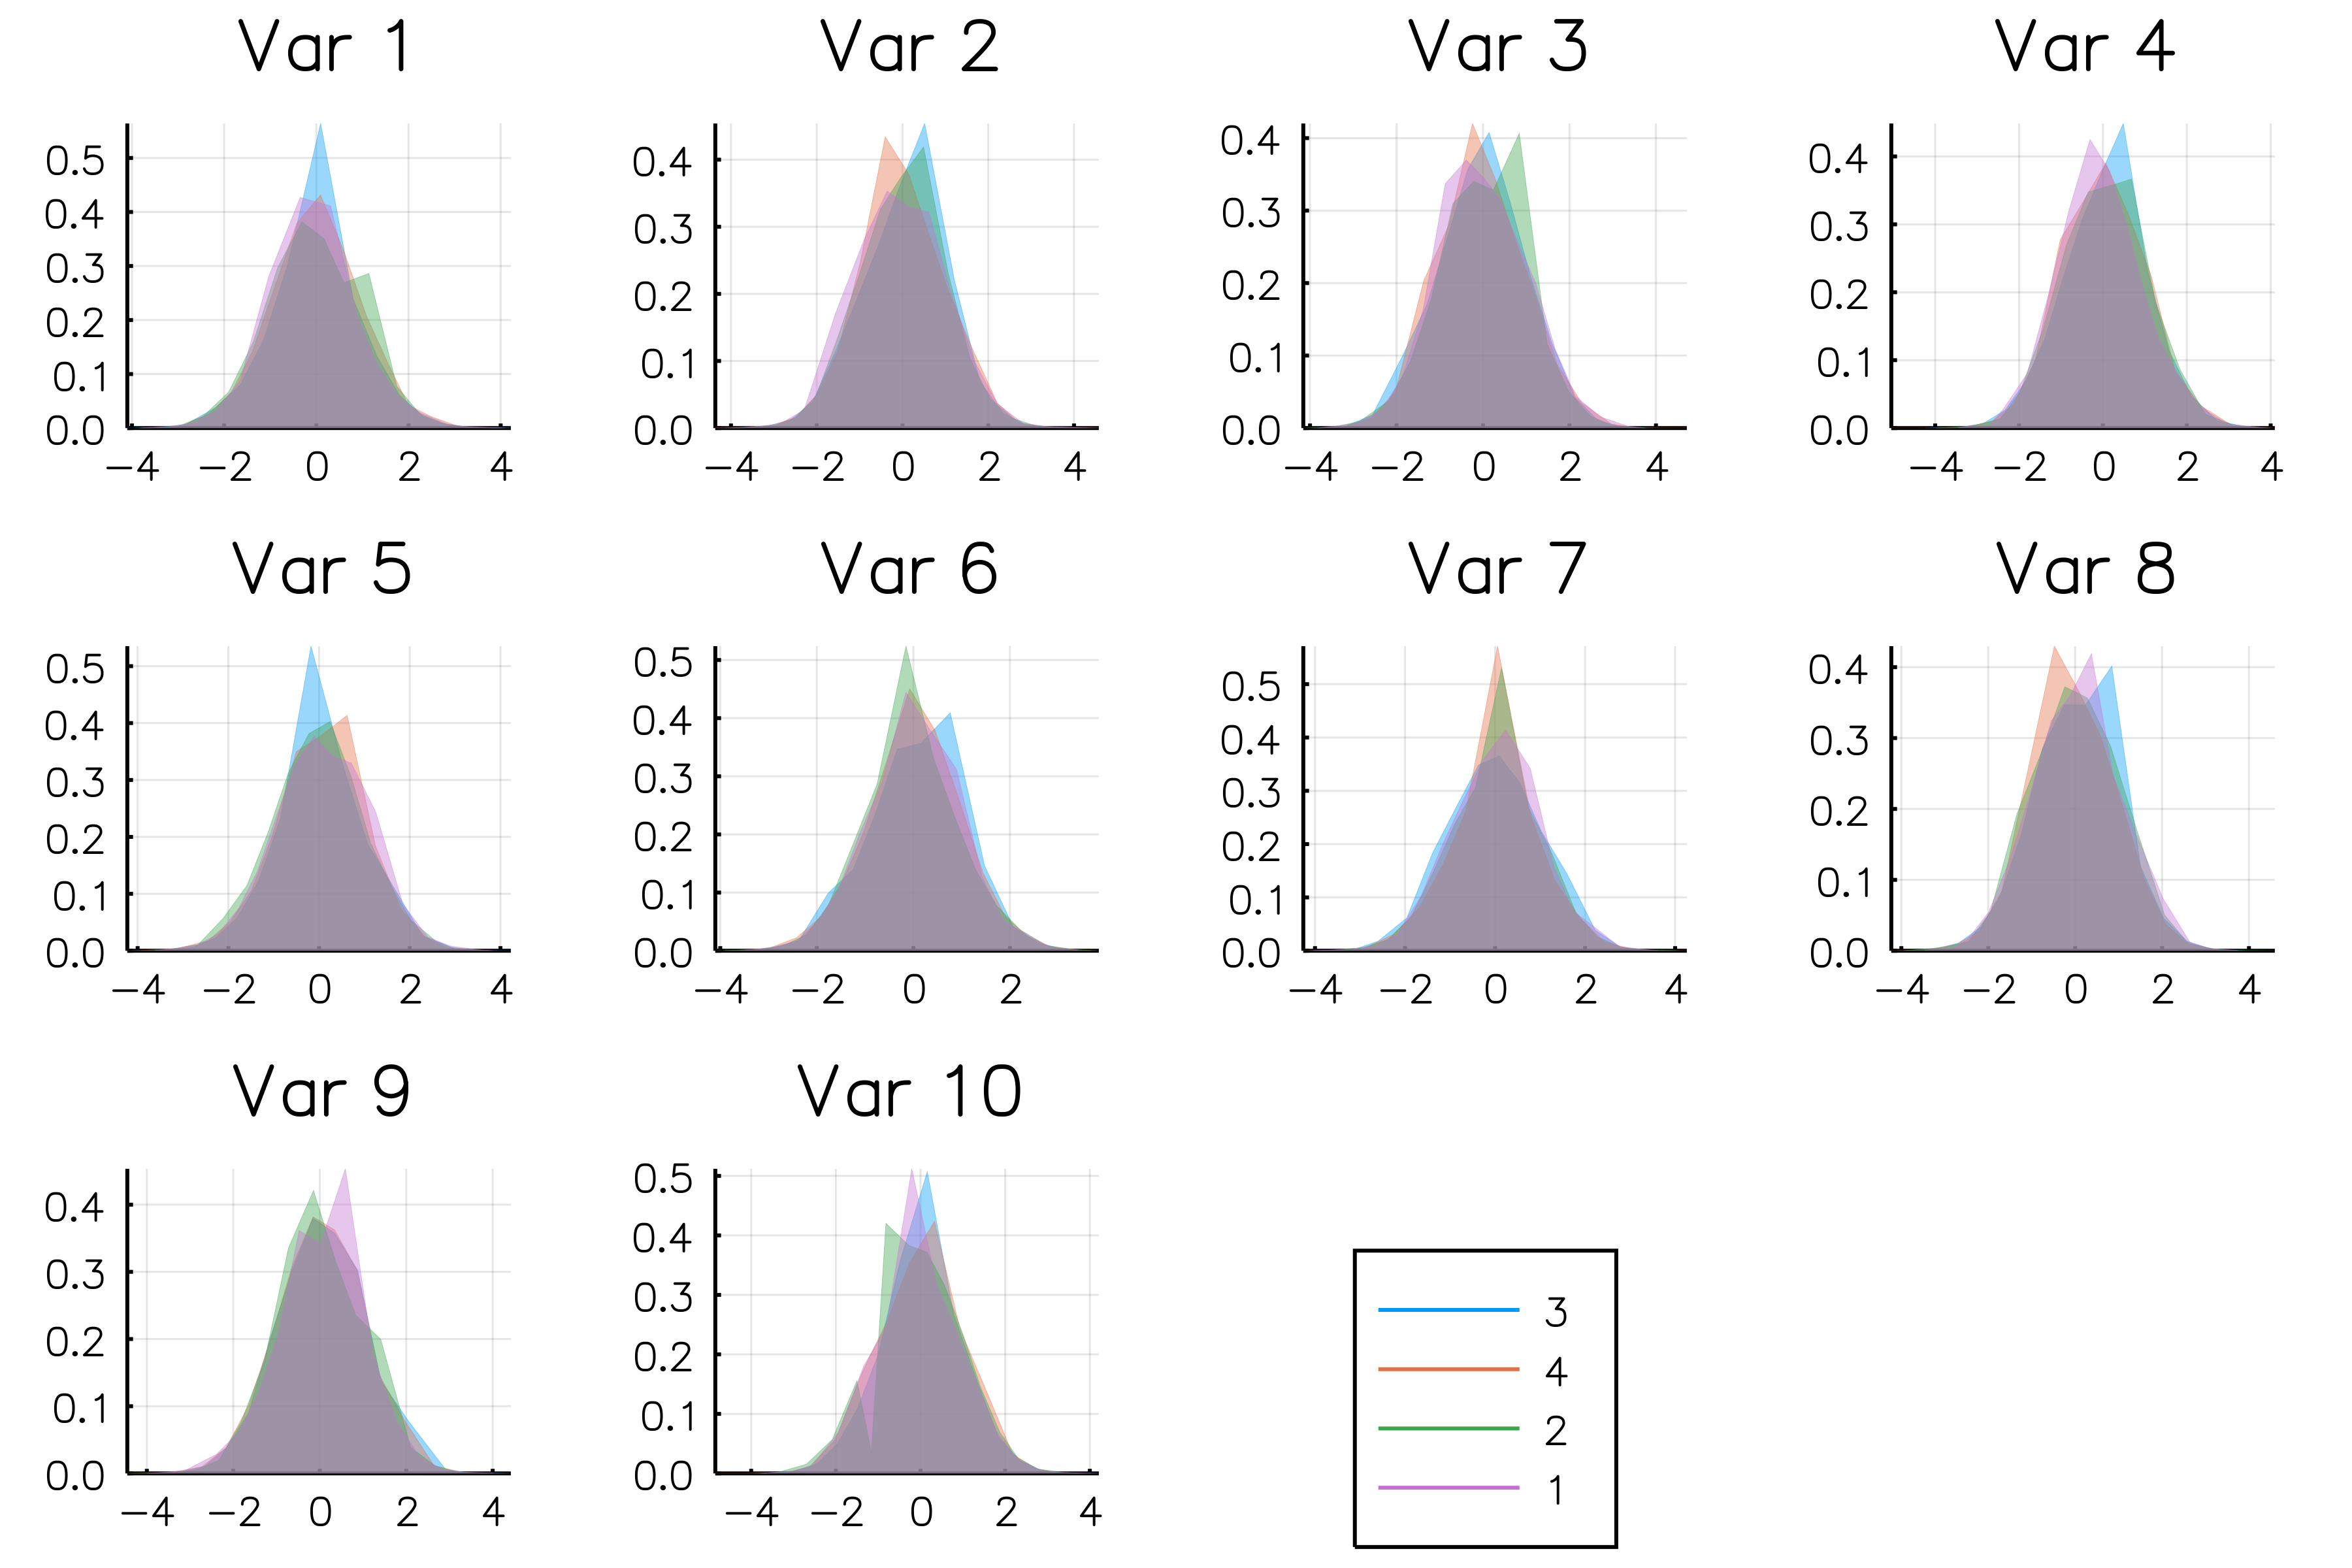

In [26]:
plot(o)

## Decision Trees

In [27]:
y = rand(1:4, 10^5)
x = randn(10^5, 10)

o = fit!(FastTree(10, 4), (x,y))

FastTree(n=1001, size=149, maxsize=5000, splitsize=1000)

In [28]:
mean(y .== classify(o, x))

0.25468

## Random Forests

In [29]:
o = fit!(FastForest(10, 4), (x,y))

FastForest(n=100000, nt=100, b=3, avg_size=1.88)

In [30]:
mean(y .== classify(o, x))

0.25227

## Regularized Empirical Risk Models

- Singleton loss function:
    - Linear predictor
    - Element-wise tuning parameter

$$\ell_i(x_i^T\beta) + \sum_{j=1}^d \lambda_j \psi(\beta_j)$$

- Use any Loss
    - `L2DistLoss()`
    - `L1DistLoss()`
    - `QuantileLoss(q)`
    - `L1HingeLoss()`
    - `LogitMarginLoss()`
    - ...
- With any Penalty
    - `NoPenalty()`
    - `L1Penalty()`
    - `L2Penalty()`
    - `ElasticNetPenalty()`
    - ...
- And any stochastic approximation method
    - `SGD()`
    - `ADAGRAD()`
    - `ADAM()`
    - `RMSPROP()`
    - `OMAS()`
    - `MSPI()`
    - ...

In [31]:
x = randn(10^5, 5)
y = x * linspace(-1, 1, 5) + randn(10^5)

o = StatLearn(5, L1DistLoss(), NoPenalty())

fit!(o, (x,y))

StatLearn: SGD | mean(λ)=0.0 | L1DistLoss | NoPenalty | nobs=100000 | nvars=5

In [32]:
coef(o)

5-element Array{Float64,1}:
 -1.01811  
 -0.518852 
  0.0153707
  0.51107  
  0.981825 

In [33]:
o2 = StatLearn(5, L2DistLoss(), L1Penalty(), MSPI(), ones(5))

fit!(o2, (x, y))

StatLearn: MSPI | mean(λ)=1.0 | L2DistLoss | L1Penalty | nobs=100000 | nvars=5

In [34]:
coef(o2)

5-element Array{Float64,1}:
 -0.478647 
 -0.0101905
  0.0      
  0.0442456
  0.429922 

# Extending OnlineStats

- OnlineStats functionality is based on a small interface

In [57]:
mutable struct Counter <: OnlineStat{Number}
    n::Int
    Counter() = new(0)
end
OnlineStats._fit!(o::Counter, y) = (o.n += 1)

In [58]:
fit!(Counter(), 1:100)

Counter: n=100 | value=100